<a href="https://colab.research.google.com/github/cobridi/detecao-anomalias-emissoes/blob/main/detec%C3%A7%C3%A3o-anomalias-emissoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Na Lição 7 de * Detecção de anomalias *, discutimos como detectar anomalias em séries temporais usando controle estatístico de processos e modelos auto-regressivos. Aqui aplicaremos as duas abordagens para conjuntos de dados do mundo real.


# Resultados de Aprendizagem

Você deve sair deste tutorial em Python com:

1. Compreensão da detecção de anomalias de séries temporais
2. Experiência prática com controle estatístico de processos e modelos autorregressivos para detectar anomalias em séries temporais.


# Importando



In [2]:
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
import statsmodels as ss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Python and library versions

In [3]:
packages = [matplotlib, np, pd]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]

library .      version
-------        -------
matplotlib       3.2.2
numpy           1.18.5
pandas           1.1.4


# Seção 1: Controle estatístico de processo

Nesta seção, usaremos o controle estatístico do processo (CEP) para detectar anomalias em séries temporais. Como discutimos na aula

### Dados

Como exemplo, usaremos dados de precipitação para outubro de 2018 para a cidade de Nova York (coletados no aeroporto JFK). Os dados brutos estão disponíveis no site da NOAA:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Aqui nós fornecemos uma versão limpa dos dados. Fizemos duas alterações nos dados brutos: (1) as datas foram escritas em um formato útil para a análise de séries temporais e (2) os valores de precipitação vestigial foram substituídos por zero.

In [ ]:
df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)
df_ppt.head()

,Precipitation
Date,
2018-10-01,0.00
2018-10-02,0.33
2018-10-03,0.00
2018-10-04,0.04
2018-10-05,0.00


A precipitação é dada em polegadas.

Veja muitos dias sem precipitação e grandes valores nos dias 11, 12 e 27 de outubro. Visualize os dados e resuma as estatísticas.

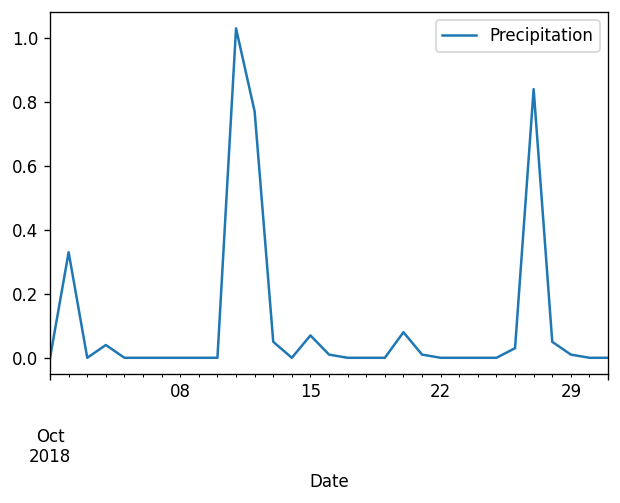

In [ ]:
plt.figure(dpi=120)
df_ppt.plot(ax=plt.gca())
plt.show();

In [ ]:
df_ppt.describe()

,Precipitation
count,31.000000
mean,0.107097
std,0.266573
min,0.000000
25%,0.000000
50%,0.000000
75%,0.045000
max,1.030000




Devido aos muitos dias sem precipitação, a média e o desvio padrão são relativamente pequenos, mas o grande valor máximo sugere que há pelo menos um ponto anômalo (11 de outubro de 2018).




### Grafico de controle 



Podemos ver nas estatísticas resumidas e no gráfico que quaisquer anomalias estarão acima da média, que é de 0,107 pol; portanto, precisamos apenas de um gráfico de controle unilateral. 

Há outra maneira de chegar à mesma conclusão. Como a precipitação não pode ser um número negativo, todos os valores possíveis abaixo da média estão no intervalo 0 <= precipitação <= 0,107 pol.), Que estão dentro de um desvio padrão (0,267 pol.) Da média e, portanto, não são anomalias.

Portanto, vamos criar um gráfico de controle unilateral.

In [ ]:
def control_plot(time_series, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

Defina um limite de 3 desvios padrão e plote os resultados.

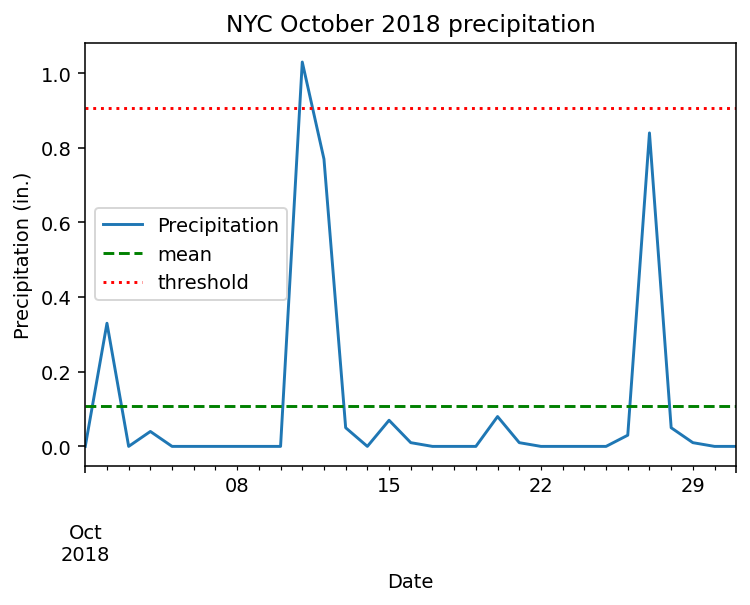

In [ ]:
anomaly_ppt = control_plot(df_ppt, 3)

Há uma anomalia. Obtenha os dados para este ponto.

In [ ]:
print(anomaly_ppt)

            Precipitation
Date                     
2018-10-11           1.03


Este resultado concorda com a nossa inspeção visual. (Para pequenos conjuntos de dados, os seres humanos são bons em detectar padrões estatísticos, como outliers, a olho nu.)



Soma acumulada (CUSUM)

Para comparação, vamos aplicar a abordagem CUSUM e ver o que encontramos. Usaremos os contornos do algoritmo na palestra.

In [ ]:
def cusum(data, mean, shift, threshold):
    '''
   as somas cumulativas alta e baixa e use-as para detecção de anomalias.
     Uma anomalia é relatada se as somas cumulativas estiverem além de um determinado limite.
    
     Args:
         data: (uma série temporal como pandas dataframe; a coluna do índice é a data no formato datetime e
         coluna 0 são dados)
         mean: média dos dados ou outra média (flutuante)
         mudança: mudança normal nos dados; o desvio padrão é recomendado (flutuante)
         threshold: limite para classificar o ponto como anomalia (float)

     Devoluções:
         cusum: as somas cumulativas alta e baixa juntas Calcular com os dados (pandas dataframe)
         anomalias: anomalias acima e abaixo do limite (pandas dataframe)
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies

E também traçaremos os resultados de nossa análise CUSUM.

In [ ]:
def cusum_plot(time_series, threshold):
    '''
    Plote as somas cumulativas alta e baixa e use-as para detecção de anomalias.
     Uma anomalia é relatada se as somas cumulativas estiverem além de um determinado limite.
    
     Args:
         time_series: (uma série temporal como pandas dataframe; a coluna de índice é date
         no formato datetime e a coluna 0 é data)
         threshold: limite para classificar o ponto como anomalia (float)

     Devoluções:
         Uma plotagem dos dados com a soma acumulada alta.
         cusum_results: as somas cumulativas alta e baixa, juntamente com dados
         e quaisquer anomalias acima e abaixo do limite (quadro de dados do pandas;
         da função cumsum)
    ''' 
    # Use a média e o desvio padrão de toda a série temporal
     # para calcular somas cumulativas
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    
    # definir limiar em termos de desvio padrão
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    ax=time_series.plot()
    ax.axhline(y=mean_, color='g', linestyle='--',label='average')
    ax.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['High_Cusum'], 
             color='k', linestyle=':',label='High Cusum')                      
    plt.legend(loc='center left')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    return cusum_results


Escolha do limiar: para o gráfico de controle, usamos 3 vezes o desvio padrão. Observe que o limite equivalente para CUSUM é * threshold * = 2, pois CUSUM inclui o * shift * (que escolhemos ser um desvio padrão) em seu cálculo da soma acumulada.

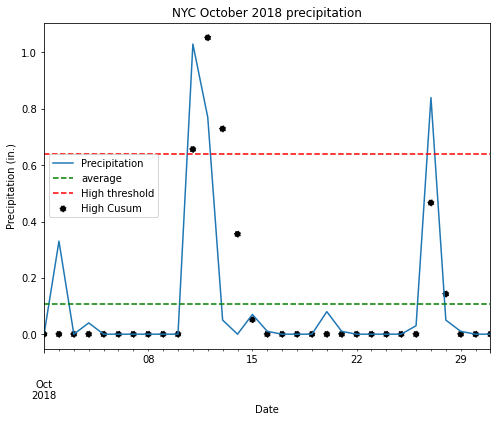

In [ ]:
cusum_plot(df_ppt, 2);

Observe que CUSUM encontra a mesma anomalia que a carta de controle (1,03 polegadas em 11 de outubro de 2018), mas também rotula os dois pontos sucessivos como anomalias. Por quê?

Os diferentes resultados refletem a diferença nos algoritmos. A tabela de controle está procurando pontos únicos e anômalos. CUSUM é sensível a alterações no comportamento dos dados. Como resultado, sinaliza pontos como anômalos até que o comportamento da série temporal retorne ao normal.

De fato, CUSUM é usado para detecção de pontos de mudança: encontrar quando a distribuição subjacente da série temporal mudou.

** Um comentário final. ** Usamos todos os dados para calcular as estatísticas da linha de base (média e desvio padrão) para a detecção de anomalias. Embora essa abordagem às vezes seja usada, a presença de anomalias nos dados pode influenciar essas estatísticas de linha de base. Uma abordagem mais rigorosa é selecionar dados considerados normais, usar esses dados para calcular as estatísticas da linha de base e só então detectar as anomalias. Vamos explorar essa idéia no Exercício 1.

# Seção 2: modelos autogressivos

Até o momento, realizamos a análise no modo offline - tínhamos todos os dados de interesse em mãos. Como resultado, ao examinar um determinado ponto, poderíamos usar o passado e o futuro (com relação a esse ponto) para calcular estatísticas como a média e o desvio padrão.

Frequentemente, estamos interessados em analisar séries temporais no modo de streaming - ou seja, à medida que os dados se tornam disponíveis. Nesse caso, qualquer modelo que usamos para detectar anomalias só pode usar o passado (com relação a um determinado ponto). Dados futuros não estão disponíveis.

Como discutido nas palestras, modelos autoregressivos são comumente usados para detecção de anomalias em fluxo e examinaremos um desses modelos abaixo.

### Dados

Usaremos outro conjunto de dados meteorológicos da cidade de Nova York (coletado no aeroporto JFK): temperaturas diárias máxima e mínima de 1 de fevereiro de 1959 a 31 de outubro de 2018.

Os dados brutos estão disponíveis no site da NOAA que usamos:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Aqui nós fornecemos uma versão limpa dos dados. Processamos os dados brutos da seguinte forma: (1) as datas foram escritas em um formato útil para a análise de séries temporais e (2) dois valores ausentes foram preenchidos.

As duas datas que não tinham valores (para a temperatura máxima ou mínima) foram 1º de dezembro de 1959 e 1º de maio de 1960. Para os propósitos deste caderno, adicionamos valores anômalos a essas datas, como mostrado abaixo. (Se não estivéssemos estudando a detecção de anomalias, teríamos adicionado valores correspondentes às temperaturas médias do dia anterior e do dia seguinte para evitar lacunas na série temporal.)

In [ ]:
df_nyc_temp = pd.read_csv('nyc_daily_temp_final.csv', parse_dates=True, index_col=0)

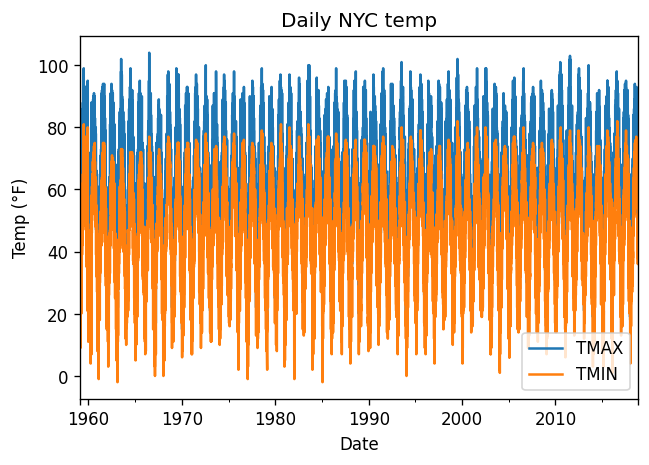

In [ ]:
plt.figure(dpi=120)
df_nyc_temp.plot(ax=plt.gca())
plt.title('Daily NYC temp')
plt.xlabel('Date')
plt.ylabel('Temp (°F)')
plt.show()


Não é fácil ver se existem anomalias com tantos pontos. Vejamos as estatísticas para TMAX (a temperatura diária máxima) e TMIN (a temperatura diária mínima).

In [ ]:
df_nyc_temp.describe()

,TMAX,TMIN
count,21823.000000,21823.000000
mean,61.548091,47.129496
std,17.585690,16.468738
min,8.000000,-2.000000
25%,48.000000,34.000000
50%,62.000000,47.000000
75%,77.000000,62.000000
max,104.000000,82.000000



O valor mais alto de TMAX (104 ° F) e o valor mais baixo de TMIN (-2 ° F) são bastante extremos. Mas são essas anomalias?

E as anomalias que semeamos nas datas com valores ausentes?



Em 1º de dezembro de 1959, o TMAX e o TMIN estão 40 ° F * mais quentes * do que o previsto por uma interpolação linear.

In [ ]:
df_nyc_temp.loc['1959-11-30':'1959-12-02']

,TMAX,TMIN
DATE,,
1959-11-30,38,26
1959-12-01,95,80
1959-12-02,51,33


Para 1º de maio de 1960, o TMAX e o TMIN estão 40 ° F * mais frios * do que o que uma interpolação linear poderia prever.

In [ ]:
df_nyc_temp.loc['1960-4-30':'1960-5-02']

,TMAX,TMIN
DATE,,
1960-04-30,60,50
1960-05-01,22,7
1960-05-02,64,43


Vamos detectar esses pontos como anomalias?

### Modelando

Usaremos um modelo auto-regressivo para detectar anomalias. Aqui, examinaremos o TMAX e deixaremos o TMIN para o Exercício 2.

Começamos criando um quadro de dados apenas de TMAX

In [ ]:
df_nyc_tmax=df_nyc_temp[['TMAX']]

Verifique se o novo quadro de dados está conforme o esperado.

In [ ]:
df_nyc_tmax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21823 entries, 1959-02-01 to 2018-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TMAX    21823 non-null  int64
dtypes: int64(1)
memory usage: 981.0 KB


In [ ]:
df_nyc_tmax.head()

,TMAX
DATE,
1959-02-01,24
1959-02-02,26
1959-02-03,38
1959-02-04,44
1959-02-05,46


Como linha de base para o modelo de regressão automática, podemos verificar o que um gráfico de controle revela como anomalias. Em contraste com o exemplo da precipitação, aqui podemos ter anomalias em ambos os lados da média, portanto modificamos * control_plot * para se tornar um gráfico de controle completo de dois lados.

In [ ]:
def control_plot_full(time_series, threshold):
    '''
    Cria um gráfico de controle frente e verso de uma série temporal
     (limiar de plotagem acima e abaixo da média)
     Além disso, retorna a lista de pontos que excedem o limite
     ou seja, pontos para os quais o valor> média + limite * (desvio padrão)
     e valor <média - limiar * (desvio padrão)
    
     Args:
         time_series: (pandas dataframe; a coluna de índice é a data no formato datetime e
         coluna 0 são dados)
         threshold: limite para detecção de anomalias (float)

     Devoluções:
         Gráfico de controle de time_series
         anomalias: anomalias que excedem o limite (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:, 0].mean()
    stdev_= time_series.iloc[:, 0].std()
    time_series.plot()
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle=':', label='high threshold')
    plt.axhline(y=mean_-threshold*stdev_, color='m', linestyle=':', label='low threshold')
    plt.legend(loc='upper right')
    plt.title('NYC Temperature')
    plt.ylabel('Temp (F)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    # Create dataframe of anomalies that exceed the threshold
    anomaly_mask = (np.abs(time_series.values - mean_) > threshold*stdev_)
    anomalies = time_series[anomaly_mask]
    return anomalies

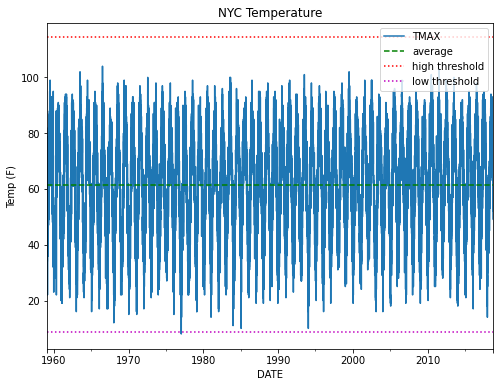

,TMAX
DATE,
1977-01-17,8


In [ ]:
control_plot_full(df_nyc_tmax, 3)

Encontramos apenas uma anomalia: o mínimo de TMAX.

Para o nosso modelo de regressão automática. Uma visão geral de tais modelos (com referências para estudos adicionais) é fornecida na palestra; uma discussão detalhada vai além do escopo das lições sobre detecção de anomalias.

** Nota_1 **: pode ser necessário um trabalho significativo para encontrar um modelo de regressão automática bem-sucedido e não reivindicamos que o modelo apresentado aqui seja o ideal. Os parâmetros foram escolhidos para ter um tempo de execução razoável.

** Nota_2 **: Existem modelos que explicitamente incorporam _ efeitos sazonais_ durante a modelagem, como a função SARIMAX dos modelos estatísticos. A duração de um ciclo completo não pode ser muito longa para a série convergir; portanto, as estações anuais não funcionam bem com dados diários (cada estação tem 365 pontos de dados). Um tratamento mais sofisticado, como fazer uma análise de Fourier e depois subtrair o componente anual, normalmente seria feito nesse caso.

** Nota_3 **: Os modelos de regressão automática em python exigem que as séries temporais analisadas tenham uma frequência de data apropriada, e é por isso que é importante verificar se há valores ausentes como uma etapa de pré-processamento. Se o time_series estiver completo, muitos pacotes que lidam com time_series podem inferir a frequência, mesmo que não seja fornecida.

In [ ]:
print(df_nyc_tmax.index.inferred_freq)

D




Frequência diária. Isso é bom! Vamos deixar explícito!

In [ ]:
df_nyc_temp.index.freq=df_nyc_tmax.index.inferred_freq

E agora, para ajustar nossos dados ao modelo.

In [ ]:
tmax_sar=ARIMA(df_nyc_tmax, order=(1,1,4)).fit()

tmax_sar.summary()

Não discutiremos as estatísticas relatadas, exceto para dizer que ela inclui o desvio padrão dos resíduos (6.516), que usaremos posteriormente.

Verificamos os diagnósticos para verificar se as premissas subjacentes ao modelo são atendidas e também para obter informações adicionais sobre a qualidade do ajuste. Isso é feito usando um gráfico Q-Q (verificando se os resíduos seguem uma distribuição normal), investigando os resíduos por padrões temporais e plotando um histograma dos resíduos

In [ ]:
# Get the predicted standard deviation. This is the 6.516 we saw earlier
sigma_pred = tmax_sar.resid.std()
# Calculate the standardized residuals from the (regular) residuals
tmax_std_resid = tmax_sar.resid/sigma_pred

plt.title('Patterns in residual')
plt.plot(tmax_std_resid);

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.distplot(tmax_std_resid.values, bins=50, ax=ax);
stats.probplot(tmax_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

Para detecção de anomalias, focamos no gráfico superior: resíduos padronizados. O residual padronizado é o residual (a diferença entre o valor observado e o valor previsto) dividido pelo desvio padrão previsto (a raiz quadrada da variação prevista mencionada acima). É uma versão mais sofisticada do z-score que discutimos na 1 aula.

Uma regra prática para detectar anomalias com resíduos padronizados: anomalias são pontos para os quais a magnitude dos resíduos padronizados é maior que 4. Vamos encontrar esses pontos.

In [ ]:
# Reportar as anomalias
anomaly_mask = np.abs(tmax_std_resid) > 4
tmax_anomalies = tmax_std_resid[anomaly_mask]
print(tmax_anomalies)

Our model found both of the seeded anomalies (Dec. 1, 1959 and May 1, 1960). 

The model did not find the lone anomaly detected by the control plot (January 17, 1977), but it did find several others that were not picked up by the control plot. 

The next step would be to vary the parameters of the autoregression model and check how robust these findings are, but as that belongs to the realm of time series analysis, we will stop here.